<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/02_5_grad_cam_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNの可視化 (Gradient-weighted Class Activation Mapping; Grad-CAM)

---

## 目的
Gradient-weighted Class Activation Mapping (Grad-CAM)の仕組みを理解する.

Grad-CAMを用いてCIFAR-10データセットに対するネットワークの判断根拠の可視化を行う．

## Gradient-weighted Class Activation Mapping (Grad-CAM)
Grad-CAM[1]は，逆伝播時の勾配を用いることでCNNを可視化する手法です．
Grad-CAMは，逆伝播時の特定のクラスにおける勾配をGlobal Average Pooling (GAP)[2]により空間方向に対する平均値を求め，各特徴マップに対する重みとします．
その後，獲得した重みを各特徴マップに重み付けして，重み付けした特徴マップを全て加算します．
最後に加算した特徴マップにReLUを適用することでAttention mapを獲得します．
02_CAM.ipynbで使用したClass Activation Mapping (CAM)[3]は，ネットワークの一部をGAPに置き換える必要があるため，Attention mapを獲得するためにネットワークを学習させる必要があります．一方で，Grad-CAMはネットワークの順伝播時の特徴マップと逆伝播時の勾配を用いてAttention mapを獲得します．そのため，学習済みの様々なネットワークからAttention map を獲得することができます．
逆伝播時のクラス$c$に対する$k$番目の勾配に対する重み $\alpha^{c}_{k}$は，以下の式のように表すことができます．

$$\alpha^{c}_{k}=\frac{1}{Z}\sum_{x,y}\frac{\partial y^c}{\partial f^{k}_{x,y}}$$
ここで，$Z$は勾配の空間方向に対する値の数，$y^c$はクラス$c$に対する出力，$f^{k}_{x,y}$は特徴マップを示します．
その後，以下の式よりクラス$c$に対するAttention map $M^{c}_{\mathrm{Grad-CAM}}$を獲得します．

$$M^{c}_{\mathrm{Grad-CAM}}={\rm ReLU}\left( \sum_{k}\alpha^{c}_{k}f^{k} \right)$$

<img src="https://github.com/himidev/Lecture/blob/main/11_cnn_pytorch/02_5_grad_cam/grad-cam.png?raw=true" width = 100%>


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [ ]:
# モジュールのインポート
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD, lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import torchsummary

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットの読み込みとData Augmentation

学習データ（CIFAR10データセット）を読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです．

今回はImageNetデータセットで事前に学習したモデルを利用するため，入力サイズをサイズを224ピクセルにします．また，各チャンネルの平均値を基準に平均が0，分散が分散が1になるようにNormalizeを用いて正規化します．

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transform_train, download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform_test, download=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## ネットワークモデルの定義
今回は，ImageNetで事前に学習された学習済みモデルを用いて，転移学習を行います．転移学習とは，ある領域における学習済みモデル（あるデータセットで学習したニューラルネットワーク）を別の領域（別のデータセットでの学習）に活用し，効率的に学習を行う方法です．学習済みモデルには，ResNet-18を利用して学習します．`pretrained = True`にすると，ImageNetで学習したモデルを利用できます．ここで，ImageNetは1,000クラスのデータセットです．すなわち，ImageNetで学習したResNet-18の出力層のユニット数は1,000になっています．転移学習に利用するCIFAR-10データセットは10クラスなので，出力層のユニット数を10に変更します．

また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します． 
これにより，GPUを用いた演算が可能となります．
学習を行う際の最適化方法としてモーメンタムSGD (モーメンタム付き確率的勾配降下法) を利用します． 
また，学習率を0.001，モーメンタムを0.9として引数に与えます．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．


In [ ]:
model = models.resnet18(pretrained=True)
print("======== Original netowrk architecutre ========\n")
print(model)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
print("======== Fine-funing netowrk architecutre ========\n")
print(model)

if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))


======== Original netowrk architecutre ========

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## 学習
１回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を10とします．
CIFAR10の学習データサイズを取得し，１エポック内における更新回数を求めます．
学習モデルに`image`を与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベル`label`との誤差をsoftmax coross entropy誤差関数で算出します．
また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．


In [ ]:
# ミニバッチサイズ・エポック数の設定
batch_size = 64
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()


start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        y = model(image)
        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))


epoch: 1, mean loss: 0.9835640828704834, mean accuracy: 0.6599, elapsed_time :321.35719180107117


KeyboardInterrupt: ignored

## テスト
学習したネットワークモデルを用いて評価を行います．

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / len(test_data)))

test accuracy: 0.8865


##Grad-CAMによるAttention mapの可視化
Grad-CAMを利用するために必要なツールをインストールします．
Grad-CAMは，`pytorch-gradcam`というツールをインストールすることで簡単に利用することができます．


In [ ]:
!pip install pytorch-gradcam

Grad-CAMによりAttention mapを可視化して，ネットワークの判断根拠を確認してみます． 再度，実行することで他のテストサンプルに対するAttention mapを可視化することができます． pred (prediction) は認識結果，conf (confidence) は認識結果に対する信頼度を示しています．

Files already downloaded and verified
torch.Size([16, 3, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


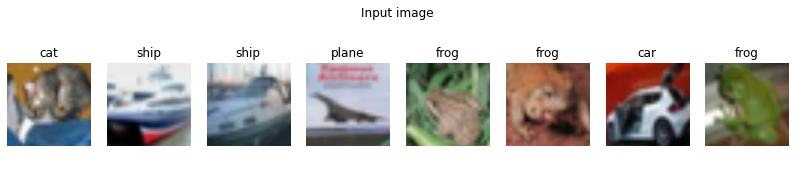

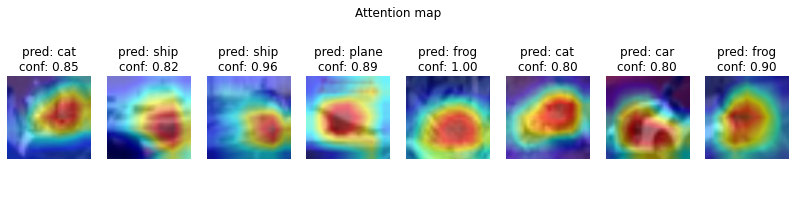

In [ ]:
import matplotlib.pyplot as plt
from gradcam.utils import visualize_cam
from gradcam import GradCAM
import cv2
import numpy as np

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),

])

test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform_test, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

classes_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Grad-CAM
target_layer = model.layer4 # ex., layer1, layer2, layer3, layer3[1], layer4[0]
gradcam = GradCAM(model, target_layer)

softmax = nn.Softmax(dim=1)

def save_gradcam(gcam, raw_image):
    h, w, _ = raw_image.shape
    gcam = gcam * 255.0
    gcam = np.uint8(gcam)
    gcam = gcam.transpose((1, 2, 0))
    v_list.append(raw_image)
    att_list.append(gcam)

v_list = []
att_list = []
for image, label in test_loader:
    if use_cuda:
        image = image.cuda()
        label = label.cuda()
    normed_input_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(image)
    outputs = model(normed_input_img)
    outputs = softmax(outputs)
    conf_data = outputs.data.topk(k=1, dim=1, largest=True, sorted=True)
    _, predicted = outputs.max(1)
    d_inputs = image.data.cpu().numpy()
    in_b, in_c, in_y, in_x = image.shape

    for i in range(in_b):
        input = image[i,:,:,:]
        normed_torch_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(input)[None]

        v_img = d_inputs[i,:,:,:]
        v_img = v_img.transpose(1, 2, 0) * 255
        v_img = np.uint8(v_img)

        mask, _ = gradcam(normed_torch_img)
        heatmap, result = visualize_cam(mask, input)

        save_gradcam(result, v_img)
    break

# Show attention map
cols = 8
rows = 1

fig = plt.figure(figsize=(14, 3.0))
plt.title('Input image')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        cls = label[c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        plt.title('{}'.format(classes_list[cls]))
        ax.imshow(v_list[cols * r + c])
        ax.set_axis_off()
plt.show()

fig = plt.figure(figsize=(14, 3.5))
plt.title('Attention map')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        pred = predicted[c].item()
        conf = conf_data[0][c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(att_list[cols * r + c])
        plt.title('pred: {}\nconf: {:.2f}'.format(classes_list[pred], conf))
        ax.set_axis_off()
plt.show()

#課題
1. Attention mapを可視化する層を変更して，Attention mapの変化を確認してみましょう．


In [ ]:
#ここにコードを書く

# 参考文献
- [1] S. Ramprasaath, R., C. Michael, D. Abhishek,
V. Ramakrishna, P. Devi, and B.
Dhruv, "Grad-CAM: Visual explanations from deep networks
via gradient-based localization". In International Conference
on Computer Vision, pp. 618–626, 2017.

- [2] B. Zhou, A. Khosla, A. Lapedriza, A. Oliva,
and A. Torralba, "Learning deep features for discriminative
localization". In 2016 IEEE Conference on Computer
Vision and Pattern Recognition, pp. 2921–2929, 2016.

- [2] M. Lin, Q. Chen, and S. Yan, "Network in network".
In 2nd International Conference on Learning Representations,
Banff, AB, Canada, April 14-16, 2014, Conference
Track Proceedings, 2014.